#Cat or Dog

A Data Science project for the module "Statistical Methods for Machine Learning" that uses Convolutional Neural Networks to classify if a given image portrays a cat or a dog


## Step 1: Data Gathering
Upload the dataset from Google Drive folder

In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive/', force_remount=True)
!unzip -q /content/gdrive/MyDrive/CatsDogs.zip


MessageError: ignored

## Step 2: Data Exploration and Preprocessing
In this section we test if the dataset contains corrupted images and proceed to recover the ones which are recoverable

In [ ]:
img_list = [
    os.path.join(dirname, filename)
    for dirname, _, filenames in os.walk(".")
    for filename in filenames
    if ".jpg" in filename and "MyDrive" not in dirname
]

Check eventual class inbalance

In [ ]:
cnt_cats = len([img for img in img_list if img.find("CatsDogs/Cats")>1])
cnt_dogs = len(img_list) - cnt_cats
print(cnt_cats)
print(cnt_dogs)

NameError: ignored

Functions to check and recover corrupted images

In [ ]:
import tensorflow as tf
from PIL import Image

def img_curator(filepath):
  try:
    img = Image.open(filepath)
    img.save(filepath)
  except IOError:
    return filepath
  return 0

In [ ]:
def corrupted_images(images):
  corrupted = []
  for filename in images:
    try:
      img = open(filename, "rb")
      is_jfif = tf.compat.as_bytes("JFIF") in img.peek(10)
    except IOError:
      corrupted.append(filename)
    finally:
      img.close()
    if not is_jfif:
      corrupted.append(filename)
  unrecovered = []
  for image in corrupted:
    cure_chk = img_curator(image)
    if cure_chk != 0:
      unrecovered.append(image)
    else:
      continue
  return unrecovered

In [ ]:
corrupt_img_list = corrupted_images(img_list)

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [ ]:
len(corrupt_img_list)

61

In [ ]:
for corr_img in corrupt_img_list:
  os.remove(corr_img)
  img_list.remove(corr_img)

A quick glance at the images

In [ ]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [ ]:
cats = [img for img in img_list if img.find("CatsDogs/Cats")>1]
dogs = [img for img in img_list if img.find("CatsDogs/Dogs")>1]

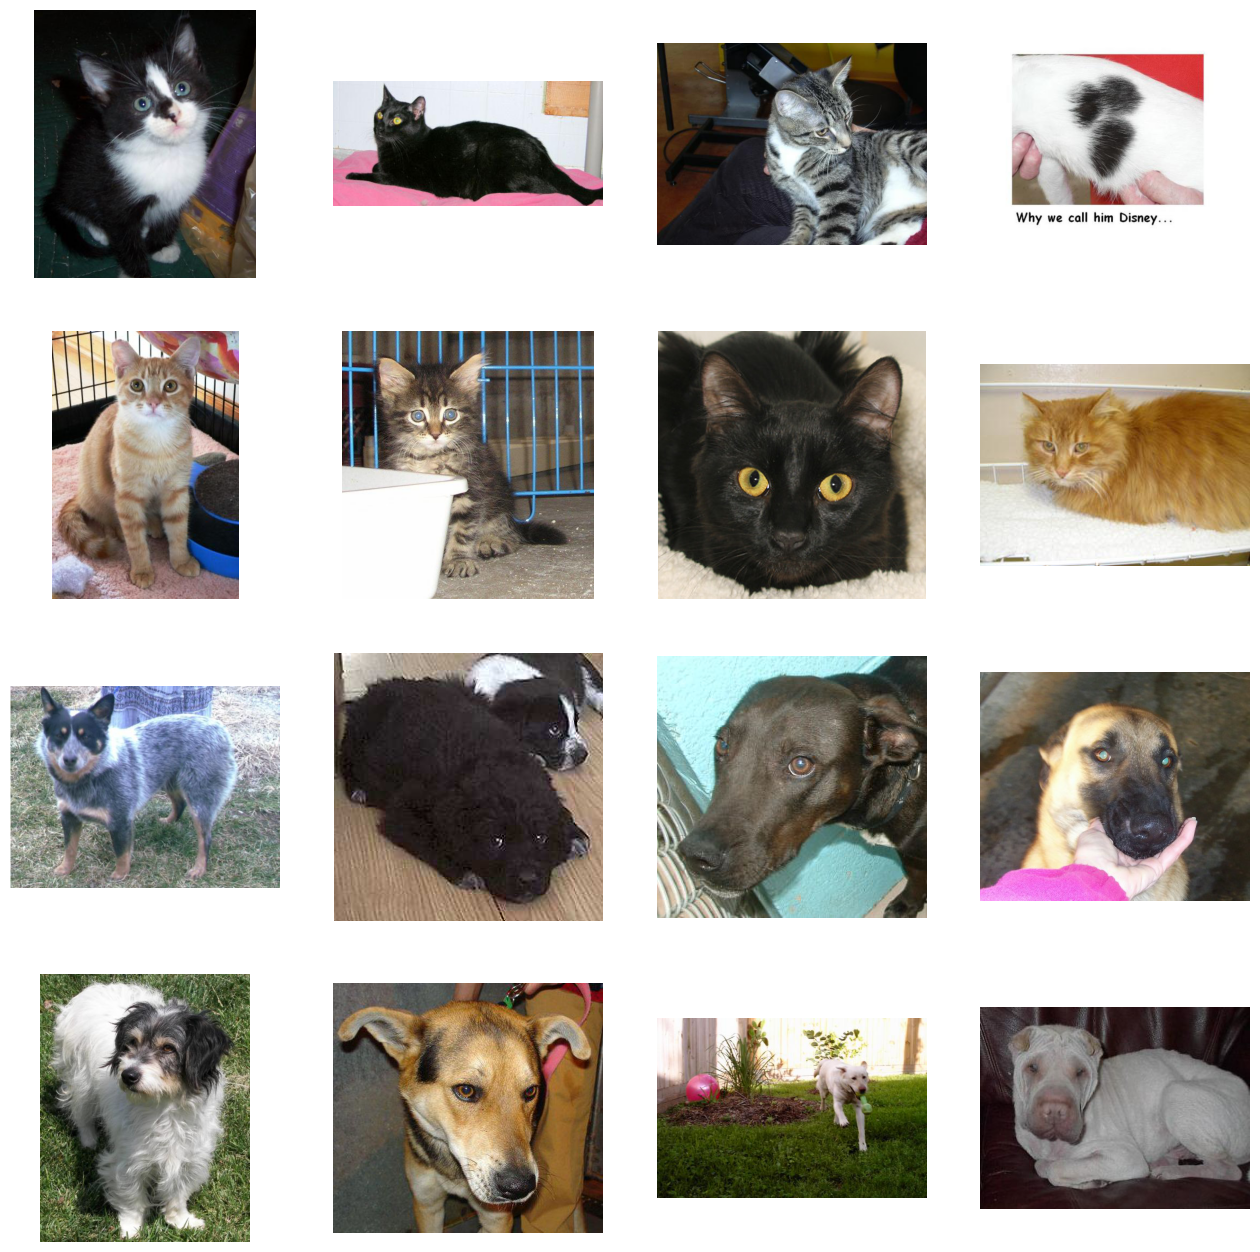

In [ ]:
nrows = 4
ncols = 4

pic_index = 0
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index += 8

next_cat_pix = [fname for fname in cats[ pic_index -8:pic_index]]

next_dog_pix = [fname for fname in dogs[ pic_index -8: pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis("Off")

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

#Step 3: Create Train, validation and test splittings
Before we proceed to build our Neural network we'll prepare our dataset to be divided into train test and validation sets

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
def dataset_partitions(data, train_split = 0.7, val_split = 0.1, test_split = 0.2):
  data_sample = data.sample(frac=1, random_state=999)
  index_test = int(test_split * len(data))
  index_train = int((test_split + val_split )* len(data))
  section_indexes = [index_test, index_train]
  val, test, train = np.split(data_sample, section_indexes)
  return train, val, test

Set columns for the dataframe 

In [ ]:
label = [img.split("/")[2] for img in img_list]
filepaths = [img.replace("./CatsDogs/", "",1) for img in img_list]

In [ ]:
df = pd.DataFrame({"file":filepaths, "label":label})

In [ ]:
train, test, val  = dataset_partitions(df)
print(len(train))
print(len(val))
print(len(test))
print(sum([len(val), len(train), len(test)]) == len(df))

17458
2494
4987
True


#Step 4: Build a CNN
Once we explored the characteristics of the dataset we build our CNN

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
train_gen = datagen.flow_from_dataframe(
            dataframe = train,
            directory = "/content/CatsDogs/",
            seed = 100,
            x_col = "file",
            y_col = "label",
            target_size = (128,128),
            class_mode="binary")

val_gen = datagen.flow_from_dataframe(
            dataframe = val,
            directory = "/content/CatsDogs/",
            seed = 100,
            x_col = "file",
            y_col = "label",
            target_size = (128,128),
            class_mode="binary")

Found 17458 validated image filenames belonging to 2 classes.
Found 2494 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation

In [ ]:
base_model = Sequential()

base_model.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = (128, 128, 3)))
base_model.add(Activation("relu"))
base_model.add(MaxPooling2D(pool_size = (2,2)))

base_model.add(Conv2D(32, (3,3)))
base_model.add(Activation("relu"))
base_model.add(MaxPooling2D(pool_size = (2,2)))

base_model.add(Flatten())
base_model.add(Dense(units = 64))
base_model.add(Activation("relu"))

base_model.add(Dense(units = 1))
base_model.add(Activation("sigmoid"))

In [ ]:
base_model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 activation_43 (Activation)  (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 61, 61, 32)        9248      
                                                                 
 activation_44 (Activation)  (None, 61, 61, 32)        0         
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                 

In [ ]:
base_model.compile(optimizer = "adam",
                   loss = "binary_crossentropy",
                   metrics = ["accuracy"])

In [ ]:
stop_early = [keras.callbacks.EarlyStopping(monitor="val_loss", patience = 5)]

history = base_model.fit(train_gen,
						validation_data = val_gen,
						epochs = 30,
						callbacks = stop_early)

Epoch 1/30
546/546 [==============================] - 68s 122ms/step - loss: 0.5990 - accuracy: 0.6665 - val_loss: 0.5178 - val_accuracy: 0.7490
Epoch 2/30
546/546 [==============================] - 66s 122ms/step - loss: 0.4791 - accuracy: 0.7713 - val_loss: 0.5135 - val_accuracy: 0.7538
Epoch 3/30
546/546 [==============================] - 66s 121ms/step - loss: 0.4132 - accuracy: 0.8093 - val_loss: 0.5310 - val_accuracy: 0.7518
Epoch 4/30
546/546 [==============================] - 67s 122ms/step - loss: 0.3404 - accuracy: 0.8505 - val_loss: 0.4691 - val_accuracy: 0.7819
Epoch 5/30
546/546 [==============================] - 70s 128ms/step - loss: 0.2761 - accuracy: 0.8837 - val_loss: 0.5262 - val_accuracy: 0.7743
Epoch 6/30
546/546 [==============================] - 68s 125ms/step - loss: 0.2044 - accuracy: 0.9192 - val_loss: 0.5747 - val_accuracy: 0.7702
Epoch 7/30
546/546 [==============================] - 69s 126ms/step - loss: 0.1387 - accuracy: 0.9479 - val_loss: 0.6738 - val_ac

Visualize results

Function to show accuracy and loss 

In [ ]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def shw_results(history):
  results = history.history
  acc = results["accuracy"]
  val_acc = results["val_accuracy"]
  loss = results['loss']
  val_loss = results['val_loss']
  epochs = range(len(acc)) 
  fig_accuracy = plt.figure()
  plt.plot(epochs, acc, label="Train")
  plt.plot(epochs, val_acc, label="Validation")
  plt.title("Training and validation accuracy")
  plt.legend()
  fig_loss = plt.figure()
  plt.plot(epochs, loss, label="Train")
  plt.plot(epochs, val_loss, label="Validation")
  plt.title("Training and validation loss")
  plt.legend()
  return fig_accuracy, fig_loss

Function to save model's results and weights

In [ ]:
import json
def save_results(model, history, modelname):
  path_dest = "gdrive/MyDrive/model_results/"
  try:
    model.save_weights(path_dest + modelname + ".h5")
  except OSError:
    model.save_weights(modelname + ".h5")
  try:
    with open(path_dest + modelname + ".json", 'w') as outfile:
      json_string = json.dumps(history.history)
      outfile.write(json_string)
  except OSError:
    with open(modelname + ".json", 'w') as outfile:
      json_string = json.dumps(history.history)
      outfile.write(json_string)

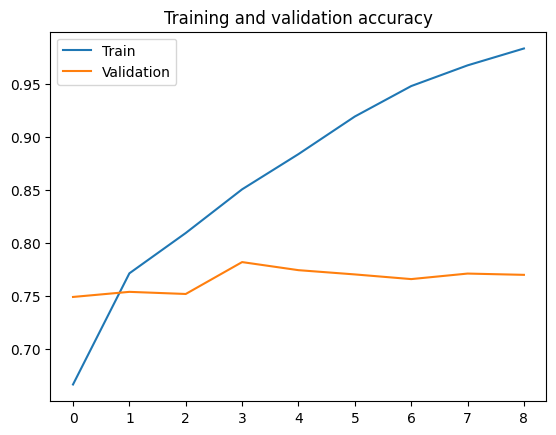

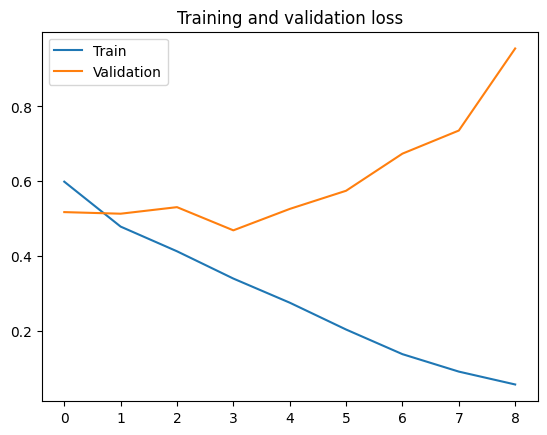

<Figure size 640x480 with 0 Axes>

In [ ]:
base_accuracy,  base_loss = shw_results(history)
plt.show()
save_results(base_model, history, "base_model")
path_dest = "gdrive/MyDrive/model_results/"
plt.savefig(path_dest + "base_model.jpg")

In [ ]:
model1 = Sequential()

model1.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = (128, 128, 3)))
model1.add(Activation("relu"))
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout(0.2))

model1.add(Conv2D(32, (3,3)))
model1.add(Activation("relu"))
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout(0.2))

model1.add(Conv2D(32, (3,3)))
model1.add(Activation("relu"))
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout(0.2))

model1.add(Flatten())
model1.add(Dense(units = 64))
model1.add(Activation("relu"))
model1.add(Dropout(0.5))

model1.add(Dense(units = 1))
model1.add(Activation("sigmoid"))

In [ ]:
model1.summary()
model1.compile(optimizer = "adam",
                   loss = "binary_crossentropy",
                   metrics = ["accuracy"])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 activation_38 (Activation)  (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 63, 63, 32)        0         
                                                                 
 conv2d_23 (Conv2D)          (None, 61, 61, 32)        9248      
                                                                 
 activation_39 (Activation)  (None, 61, 61, 32)        0         
                                                      

In [ ]:
stop_early = [keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5)]

history = model1.fit(train_gen,
					validation_data = val_gen,
					epochs = 50,
					callbacks = stop_early)

Epoch 1/50
546/546 [==============================] - 69s 122ms/step - loss: 0.6430 - accuracy: 0.6151 - val_loss: 0.5658 - val_accuracy: 0.6953
Epoch 2/50
546/546 [==============================] - 67s 123ms/step - loss: 0.5525 - accuracy: 0.7218 - val_loss: 0.5287 - val_accuracy: 0.7390
Epoch 3/50
546/546 [==============================] - 82s 151ms/step - loss: 0.5045 - accuracy: 0.7529 - val_loss: 0.4960 - val_accuracy: 0.7530
Epoch 4/50
546/546 [==============================] - 69s 126ms/step - loss: 0.4696 - accuracy: 0.7814 - val_loss: 0.4604 - val_accuracy: 0.7839
Epoch 5/50
546/546 [==============================] - 67s 123ms/step - loss: 0.4354 - accuracy: 0.8021 - val_loss: 0.4298 - val_accuracy: 0.8067
Epoch 6/50
546/546 [==============================] - 67s 123ms/step - loss: 0.4037 - accuracy: 0.8178 - val_loss: 0.4223 - val_accuracy: 0.8067
Epoch 7/50
546/546 [==============================] - 67s 123ms/step - loss: 0.3876 - accuracy: 0.8311 - val_loss: 0.4134 - val_ac

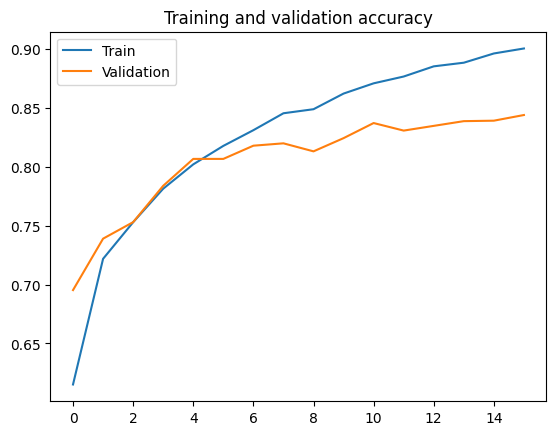

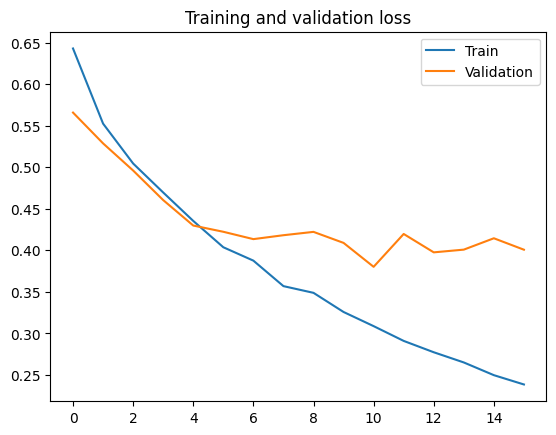

<Figure size 640x480 with 0 Axes>

In [ ]:
accuracy, loss = shw_results(history)
plt.show()
save_results(model1, history, "model1")
path_dest = "gdrive/MyDrive/model_results/"
plt.savefig("model1.jpg")

Model 1 improved in accuracy for train and validation, but we still have overfitting, so we introduce data augmentation in our train set generator to introduce new data and noise

In [ ]:
datagen_train = ImageDataGenerator(rescale = 1./255,
                                   width_shift_range = 0.25,
                                   height_shift_range = 0.25,
                                   horizontal_flip = True,
                                   rotation_range = 45)


In [ ]:
train_gen_aug = datagen_train.flow_from_dataframe(
            dataframe = train,
            directory = "/content/CatsDogs/",
            seed = 100,
            x_col = "file",
            y_col = "label",
            target_size = (128,128),
            class_mode="binary")

Found 17458 validated image filenames belonging to 2 classes.


In [ ]:
model2 = Sequential()

model2.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = (128, 128, 3)))
model2.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size = (2,2)))
model2.add(Dropout(0.2))

model2.add(Conv2D(32, (3,3)))
model2.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size = (2,2)))
model2.add(Dropout(0.2))

model2.add(Conv2D(64, (3,3)))
model2.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size = (2,2)))
model2.add(Dropout(0.2))

model2.add(Flatten())
model2.add(Dense(units = 64))
model2.add(Activation("relu"))
model2.add(Dropout(0.5))

model2.add(Dense(units = 1))
model2.add(Activation("sigmoid"))

In [ ]:
model2.summary()
model2.compile(optimizer = "adam",
                   loss = "binary_crossentropy",
                   metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 activation (Activation)     (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 61, 61, 32)        0         
                                                        

In [ ]:
stop_early = [keras.callbacks.EarlyStopping(monitor="val_loss", patience = 5)]

history = model2.fit(train_gen_aug,
					validation_data = val_gen,
					epochs = 50,
					callbacks = stop_early)

Epoch 1/50
546/546 [==============================] - 133s 221ms/step - loss: 0.6893 - accuracy: 0.5424 - val_loss: 0.6777 - val_accuracy: 0.5866
Epoch 2/50
546/546 [==============================] - 120s 219ms/step - loss: 0.6664 - accuracy: 0.5862 - val_loss: 0.6256 - val_accuracy: 0.6652
Epoch 3/50
546/546 [==============================] - 120s 220ms/step - loss: 0.6385 - accuracy: 0.6313 - val_loss: 0.5961 - val_accuracy: 0.6965
Epoch 4/50
546/546 [==============================] - 119s 217ms/step - loss: 0.6170 - accuracy: 0.6636 - val_loss: 0.5428 - val_accuracy: 0.7294
Epoch 5/50
546/546 [==============================] - 119s 218ms/step - loss: 0.6010 - accuracy: 0.6749 - val_loss: 0.5161 - val_accuracy: 0.7670
Epoch 6/50
546/546 [==============================] - 117s 215ms/step - loss: 0.5837 - accuracy: 0.6921 - val_loss: 0.5472 - val_accuracy: 0.7249
Epoch 7/50
546/546 [==============================] - 117s 214ms/step - loss: 0.5691 - accuracy: 0.7051 - val_loss: 0.4592 -

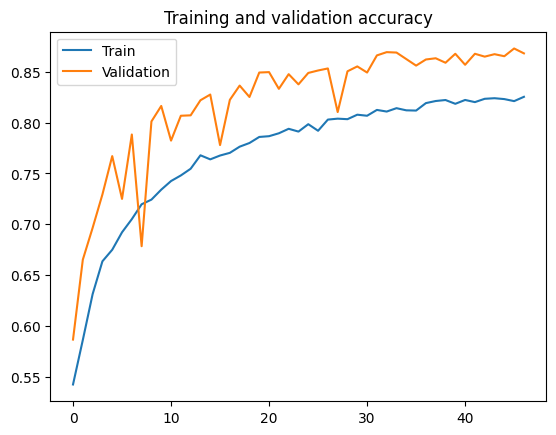

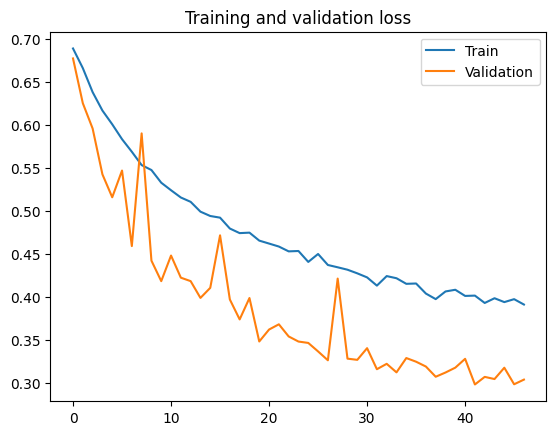

NameError: ignored

In [ ]:
accuracy, loss = shw_results(history)
plt.show()
save_results(model1, history, "model2")
path_dest = "gdrive/MyDrive/model_results/"
plt.savefig("model2.jpg")


In [ ]:
model3 = Sequential()

model3.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = (128, 128, 3)))
model3.add(Activation("relu"))
model3.add(MaxPooling2D(pool_size = (2,2)))
model3.add(Dropout(0.2))

model3.add(Conv2D(32, (3,3)))
model3.add(Activation("relu"))
model3.add(MaxPooling2D(pool_size = (2,2)))
model3.add(Dropout(0.2))

model3.add(Conv2D(64, (3,3)))
model3.add(Activation("relu"))
model3.add(MaxPooling2D(pool_size = (2,2)))
model3.add(Dropout(0.2))

model3.add(Conv2D(64, (3,3)))
model3.add(Activation("relu"))
model3.add(MaxPooling2D(pool_size = (2,2)))
model3.add(Dropout(0.2))

model3.add(Flatten())
model3.add(Dense(units = 128))
model3.add(Activation("relu"))
model3.add(Dropout(0.5))

model3.add(Dense(units = 1))
model3.add(Activation("sigmoid"))

In [ ]:
model3.compile(optimizer = "adam",
                   loss = "binary_crossentropy",
                   metrics = ["accuracy"])

In [ ]:
stop_early = [keras.callbacks.EarlyStopping(monitor="val_loss", patience = 5)]

history_md3 = model3.fit(train_gen_aug,
					validation_data = val_gen,
					epochs = 50,
					callbacks = stop_early)


Epoch 1/50
546/546 [==============================] - 126s 207ms/step - loss: 0.6939 - accuracy: 0.5101 - val_loss: 0.6902 - val_accuracy: 0.5000
Epoch 2/50
546/546 [==============================] - 110s 201ms/step - loss: 0.6830 - accuracy: 0.5633 - val_loss: 0.6697 - val_accuracy: 0.5978
Epoch 3/50
546/546 [==============================] - 108s 198ms/step - loss: 0.6597 - accuracy: 0.6016 - val_loss: 0.6107 - val_accuracy: 0.6724
Epoch 4/50
546/546 [==============================] - 111s 204ms/step - loss: 0.6318 - accuracy: 0.6357 - val_loss: 0.6059 - val_accuracy: 0.6580
Epoch 5/50
546/546 [==============================] - 110s 202ms/step - loss: 0.6048 - accuracy: 0.6712 - val_loss: 0.5726 - val_accuracy: 0.7009
Epoch 6/50
546/546 [==============================] - 109s 199ms/step - loss: 0.5859 - accuracy: 0.6880 - val_loss: 0.5467 - val_accuracy: 0.7205
Epoch 7/50
546/546 [==============================] - 109s 199ms/step - loss: 0.5708 - accuracy: 0.6996 - val_loss: 0.5487 -

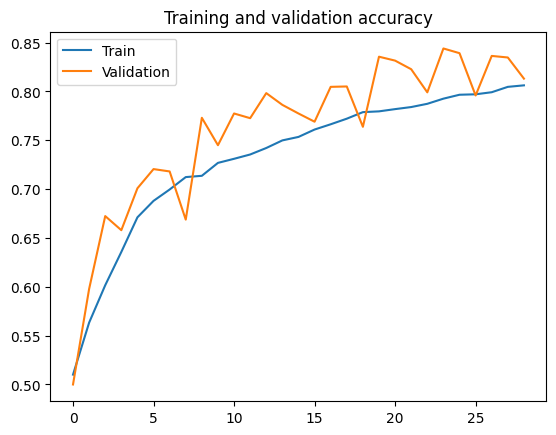

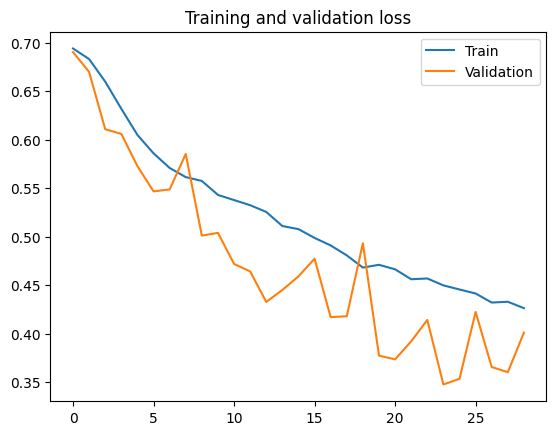

<Figure size 640x480 with 0 Axes>

In [ ]:
save_results(model3, history_md3, "model3")
accuracy, loss = shw_results(history_md3)
plt.show()
path_dest = "gdrive/MyDrive/model_results/"
plt.savefig("model2.jpg")


#Step 5: Hyperparameters tuning

We try differet cofiguration of Hyperparameters in order to gain more validation accuracy than the previous model keeping the same architecture

In [ ]:
!pip install keras_tuner
import keras_tuner as kt
def hypermodel_builder(hp):
  hidden_dropout = hp.Float("dropout_hidden_layer", min_value = 0.05, max_value = 0.3, step = 0.05)
  dense_dropout = hp.Float("dropout_flatten_layer", min_value = 0.2, max_value = 0.5, step = 0.1)
  
  model = Sequential()
  model.add(Conv2D(filters = hp.Int("convolution_1_filters", min_value = 16, max_value = 64, step = 16),
                   kernel_size = (3,3), 
                   input_shape = (128, 128, 3)))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(hidden_dropout))

  model.add(Conv2D(filters = hp.Int("convolution_2_filters", min_value = 32, max_value = 128, step = 32),
                   kernel_size = (3,3)))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(hidden_dropout))

  model.add(Conv2D(filters = hp.Int("convolution_3_filters", min_value = 64, max_value = 256, step = 64),
                   kernel_size = (3,3)))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(hidden_dropout))

  model.add(Conv2D(filters = hp.Int("convolution_4_filters", min_value = 128, max_value = 512, step = 128), 
                   kernel_size = (3,3)))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(hidden_dropout))

  model.add(Flatten())
  model.add(Dense(units = hp.Int("num_units", min_value = 64, max_value = 256, step = 64)))
  model.add(Activation("relu"))
  model.add(Dropout(dense_dropout))

  model.add(Dense(units = 1))
  model.add(Activation("sigmoid"))

  model.compile(optimizer = "adam",
                loss = "binary_crossentropy",
                metrics = ["accuracy"])
  return model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 11.7 MB/s eta 0:00:00


In [ ]:
tuner = kt.BayesianOptimization(hypermodel_builder, objective = "val_accuracy", max_trials = 15, 
                                directory = "./gdrive/MyDrive/CatsDogsClass",
                                project_name = "cats_dogs_classification",
                                overwrite = False)

In [ ]:
tuner.search_space_summary()
stop_early = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=4)]


Search space summary
Default search space size: 7
dropout_hidden_layer (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.05, 'max_value': 0.3, 'step': 0.05, 'sampling': 'linear'}
dropout_flatten_layer (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
convolution_1_filters (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
convolution_2_filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
convolution_3_filters (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
convolution_4_filters (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 128, 'sampling': 'linear'}
num_units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': 'linear'}


In [ ]:
tuner.search(train_gen_2, epochs = 50, validation_data = val_gen,
             callbacks = stop_early)

Trial 13 Complete [01h 05m 45s]
val_accuracy: 0.9099171161651611

Best val_accuracy So Far: 0.9149959683418274
Total elapsed time: 11h 56m 26s

Search: Running Trial #14

Value             |Best Value So Far |Hyperparameter
0.25              |0.05              |dropout_hidden_layer
0.2               |0.3               |dropout_flatten_layer
32                |16                |convolution_1_filters
64                |128               |convolution_2_filters
128               |192               |convolution_3_filters
128               |256               |convolution_4_filters
192               |256               |num_units

Epoch 1/50
546/546 [==============================] - 142s 253ms/step - loss: 0.6937 - accuracy: 0.5077 - val_loss: 0.6940 - val_accuracy: 0.4921
Epoch 2/50
546/546 [==============================] - 129s 237ms/step - loss: 0.6814 - accuracy: 0.5621 - val_loss: 0.6554 - val_accuracy: 0.5942
Epoch 3/50
546/546 [==============================] - 129s 237ms/step - loss

In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
best_hyperparameters.values

{'dropout_hidden_layer': 0.05,
 'dropout_flatten_layer': 0.30000000000000004,
 'convolution_1_filters': 16,
 'convolution_2_filters': 128,
 'convolution_3_filters': 192,
 'convolution_4_filters': 256,
 'num_units': 256}

Model with hyperparameters tuning


In [ ]:
hypermodel = tuner.hypermodel.build(best_hyperparameters)
history = hypermodel.fit(train_gen_aug,
                         epochs = 50,
                         validation_data = val_gen)

KeyboardInterrupt: ignored

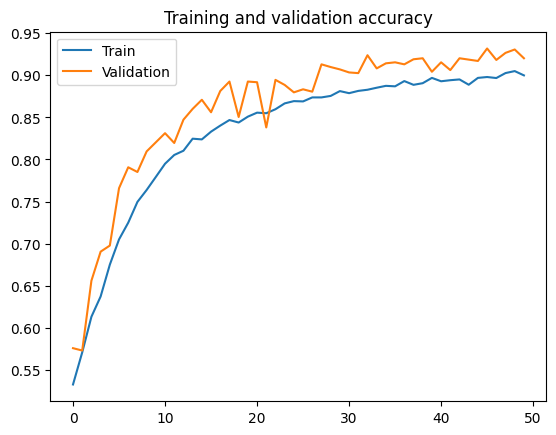

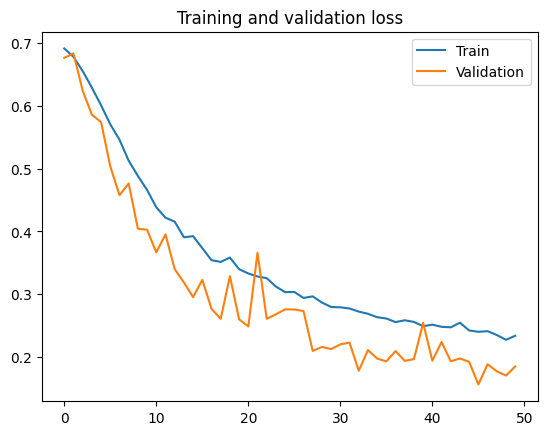

In [ ]:
save_results(hypermodel, history, "hypermodel")
accuracy, loss = shw_results(history)
plt.savefig("hypermodel.jpg")
plt.show()
path_dest = "gdrive/MyDrive/model_results/"


#Step 6 : Predictions on test set

in this section we perform a prediction with our model on test data

In [ ]:
from tensorflow.keras.preprocessing import image


In [ ]:
test_gen = datagen.flow_from_dataframe(
            dataframe = test,
            directory = "/content/CatsDogs/",
            seed = 100,
            x_col = "file",
            y_col = "label",
            target_size = (128,128),
            class_mode="binary",
            shuffle=False)

Found 4987 validated image filenames belonging to 2 classes.


In [ ]:
predictions = hypermodel.predict(test_gen)

156/156 [==============================] - 14s 88ms/step


In [ ]:
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())   

In [ ]:
class_predicted = [1 * (pred[0]>=0.5) for pred in predictions]

In [ ]:
from sklearn import metrics
report = metrics.classification_report(true_classes, class_predicted, target_names=class_labels)
print(report)   

              precision    recall  f1-score   support

        Cats       0.88      0.96      0.92      2479
        Dogs       0.95      0.88      0.91      2508

    accuracy                           0.92      4987
   macro avg       0.92      0.92      0.92      4987
weighted avg       0.92      0.92      0.92      4987



In [ ]:
hypermodel.evaluate(test_gen)

156/156 [==============================] - 14s 90ms/step - loss: 0.2055 - accuracy: 0.9158


[0.20554398000240326, 0.9157810211181641]

Confusion matrix and classification metrics


#Step 7: Cross Validation

We perform a 5-Fold external cross validation for our best model found

In [ ]:
def get_hypermodel_arc(hyper):
  model = Sequential()
  model.add(Conv2D(filters = hyper["convolution_1_filters"],
                   kernel_size = (3,3), 
                   input_shape = (128, 128, 3)))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(hyper["dropout_hidden_layer"]))

  model.add(Conv2D(filters = hyper["convolution_2_filters"],
                   kernel_size = (3,3)))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(hyper["dropout_hidden_layer"]))

  model.add(Conv2D(filters = hyper["convolution_3_filters"],
                   kernel_size = (3,3)))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(hyper["dropout_hidden_layer"]))

  model.add(Conv2D(filters = hyper["convolution_4_filters"],
                   kernel_size = (3,3)))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(hyper["dropout_hidden_layer"]))

  model.add(Flatten())
  model.add(Dense(units = hyper["num_units"]))
  model.add(Activation("relu"))
  model.add(Dropout(hyper["dropout_flatten_layer"]))

  model.add(Dense(units = 1))
  model.add(Activation("sigmoid"))

  model.compile(optimizer = "adam",
                loss = "binary_crossentropy",
                metrics = ["accuracy"])
  return model

In [ ]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits = 5, random_state = 999, shuffle = True)
acc_fold = []
loss_fold = []

In [ ]:
for train_index, test_index in kfold.split(df):
  train_fold = df['file'][train_index]
  test_fold = df['file'][test_index]

  train_df = df.loc[df["file"].isin(train_fold)]
  test_df = df.loc[df["file"].isin(test_fold)]

  train_gen = datagen_train.flow_from_dataframe(
            dataframe = train_df,
            directory = "/content/CatsDogs/",
            seed = 100,
            x_col = "file",
            y_col = "label",
            target_size = (128,128),
            class_mode="binary")
  
  test_gen = datagen.flow_from_dataframe(
            dataframe = test_df,
            directory = "/content/CatsDogs/",
            seed = 100,
            x_col = "file",
            y_col = "label",
            target_size = (128,128),
            shuffle = False,
            class_mode="binary")
  
  hypermodel = get_hypermodel_arc(best_hyperparameters.values)
  stop_early = [keras.callbacks.EarlyStopping(monitor = "loss", patience = 4)]
  history = hypermodel.fit(train_gen, epochs=30)
  scores = hypermodel.evaluate(test_gen)
  acc_fold.append(scores[1])
  loss_fold.append(scores[0])

Found 19951 validated image filenames belonging to 2 classes.
Found 4988 validated image filenames belonging to 2 classes.
Epoch 1/30
624/624 [==============================] - 132s 192ms/step - loss: 0.6833 - accuracy: 0.5525
Epoch 2/30
624/624 [==============================] - 120s 192ms/step - loss: 0.6559 - accuracy: 0.6104
Epoch 3/30
624/624 [==============================] - 120s 192ms/step - loss: 0.6191 - accuracy: 0.6573
Epoch 4/30
624/624 [==============================] - 120s 192ms/step - loss: 0.5732 - accuracy: 0.6961
Epoch 5/30
624/624 [==============================] - 119s 191ms/step - loss: 0.5425 - accuracy: 0.7233
Epoch 6/30
624/624 [==============================] - 120s 192ms/step - loss: 0.5085 - accuracy: 0.7500
Epoch 7/30
624/624 [==============================] - 120s 192ms/step - loss: 0.4815 - accuracy: 0.7697
Epoch 8/30
624/624 [==============================] - 120s 192ms/step - loss: 0.4489 - accuracy: 0.7870
Epoch 9/30
624/624 [=========================

In [ ]:
path_dest = "gdrive/MyDrive/model_results/"
cv_score = {"accuracy":acc_fold, "loss":loss_fold}
try:
    with open(path_dest + "cvscore.json", 'w') as outfile:
      json_string = json.dumps(cv_score)
      outfile.write(json_string)
except OSError:
    with open("cvscore.json", 'w') as outfile:
      json_string = json.dumps(cv_score)
      outfile.write(json_string)

In [ ]:
acc_fold

[0.9184041619300842,
 0.9051724076271057,
 0.9204089641571045,
 0.9001603722572327,
 0.8867054581642151]

In [ ]:
loss_fold

[0.1973676234483719,
 0.2196149230003357,
 0.18955422937870026,
 0.24042636156082153,
 0.25539276003837585]

In [ ]:
np.mean(acc_fold)

0.9061702728271485

In [ ]:
np.mean(loss_fold)

0.22047117948532105